In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin
import pandas as pd
from collections import Counter
import os


from scipy import signal
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [130]:
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]


In [131]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"
path ="/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"


In [135]:
def get_person_activity_data(person_id,activity):
    auscultatory_data = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory.tsv"
    basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t') 
    basic_mesures_data.fillna("", inplace=True)

    filler_to_person = basic_mesures_data[basic_mesures_data["pid"].str.contains(person_id)]
    
    activity_file_path = f"measurements_auscultatory/{person_id}/{activity}"

    filter_to_activity = (activity_file_path in list(filler_to_person['waveform_file_path']))
    #return filler_to_person[(filler_to_person['waveform_file_path'].str.contains(activity_file_path))]
    filter_to_activity = filler_to_person.loc[filler_to_person["waveform_file_path"].str.contains(activity_file_path)]


    return filter_to_activity["sbp"]



In [140]:

def get_50_avg_corrdinaes(path):
    
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]
    neglist = [ -x for x in pos_pressure]
    min_peaks, _ = find_peaks(neglist, prominence=10 )
    max_peak, _ = find_peaks(pos_pressure, prominence=10)

    #this removes all elemerns with in 40 of the mini
    unnecessary_points_overlapped = []
    for mini in list(min_peaks):
        if len(set(range(mini-40,40+mini)).intersection(set(max_peak)))>0:
            unnecessary_points_overlapped.append(int(mini))

    combo_list =  list(min_peaks)+ (unnecessary_points_overlapped)
    combo_list = [int(i) for i in combo_list]

    # juts deleted stuff from both lists if its in tht 40 range 
    # THIS IS THE MOST IMPORTANT 
    most_accurate_mins = [k for k,v in Counter(combo_list).items() if v==1]

    diffrences_new_min = np.diff(most_accurate_mins)
    mean_new_min = float(diffrences_new_min.mean())

    # overlapping every beat 
    all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]


    for i in range(len(most_accurate_mins)-1):
        if (int(most_accurate_mins[i+1]) -int(most_accurate_mins[i]))< get_stats(diffrences_new_min)[4] :
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]

            x_range = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            x_of_shift = [int(x - x_range[0]) for x in x_range]

            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]

            for x_indi in range(len(x_range)):
                all_overlaps[x_indi].append(int(y_rotated[x_indi]-start_end_line[x_indi]))
            
            
            



    #to get data for the overall mean 
    all_overlaps_means = []
    # mean for each row
    for lists in all_overlaps:
        all_overlaps_means.append(np.mean(lists))

    all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']




    #THIS IS THE list of x's
    data_points_average_overlapped = list(zip(all_overlaps_means, list(range(len(all_overlaps_means)))))
    

    #here is samppleing 50 pints
    resampled_y = signal.resample(all_overlaps_means, 50)
    resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)
    new_50 = [[x,y] for x, y in zip(resampled_x, resampled_y)]

    return new_50


In [223]:
all_points= []
all_sbp = []

for person in os.listdir("/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory"):
    if "a" in person:
        for activities in os.listdir("/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/"+person):
            #print(activities)

            points= get_50_avg_corrdinaes("/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/"+person+"/"+activities)
            
            spds_values = float(get_person_activity_data(person,activities ))
            all_points.append(points)
            all_sbp.append(spds_values)


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))


<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))


<class 'numpy.ndarray'>


/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activities ))
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rc

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/1970612302.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  basic_mesures_data.fillna("", inplace=True)
/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_30753/3517650711.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spds_values = float(get_person_activity_data(person,activiti

mean Sq 20.787446120689655
r2  0.7947611858710966


Text(0, 0.5, 'predicted sbp')

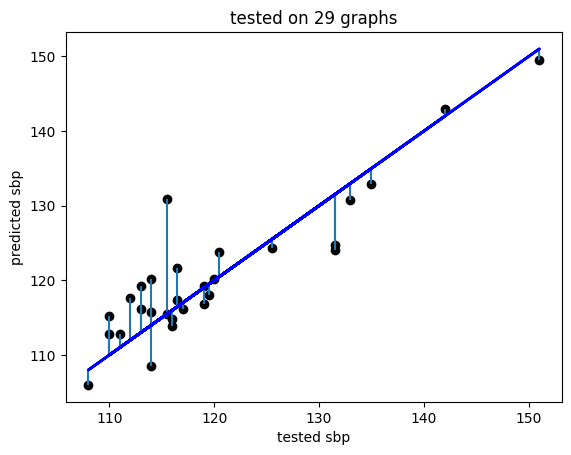

In [242]:
all_points = np.array(all_points)
all_points = all_points.reshape(all_points.shape[0], -1)


X_train, X_test, Y_train, Y_test = train_test_split(all_points, all_sbp, test_size=0.3)
model = LinearRegression()


the_fit= model.fit(all_points, all_sbp)
score  = model.score(all_points, all_sbp)
y_predict = model.predict(X_test)


for i in range(len(y_predict)):

    plt.vlines(x = Y_test[i], ymin =y_predict[i] , ymax = Y_test[i])

print("mean Sq",mean_squared_error(Y_test, y_predict))
print("r2 ",r2_score(Y_test, y_predict))

plt.scatter(Y_test, y_predict,  color="black", )
plt.plot(Y_test, Y_test, color="blue", linewidth=2)

plt.title(f"tested on {len(Y_test)} graphs")

plt.xlabel("tested sbp")
plt.ylabel("predicted sbp")

